## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [72]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [73]:
train, test = keras.datasets.cifar10.load_data()

In [74]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [75]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [76]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    output_layer = keras.layers.Dense(units=output_units,
                                      activation='softmax',
                                      name='output')(x)
    model = keras.models.Model(inputs=[input_layer],
                              outputs=[output_layer])
    return model

In [77]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [78]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4., ce_weights=0.7, fcl_weights=0.3):
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    def CE_focal_loss(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
        return (ce_weights*ce_loss) + (fcl_weights*tf.reduce_mean(reduced_fl) )
    return CE_focal_loss       

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [79]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(), metrics=['accuracy'], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_88 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_89 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_90 

50000/50000 [==============================] - 4s 78us/step - loss: 1.7148 - accuracy: 0.5938 - val_loss: 2.2258 - val_accuracy: 0.4785
Epoch 12/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.6590 - accuracy: 0.6064 - val_loss: 2.2475 - val_accuracy: 0.4774
Epoch 13/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.6050 - accuracy: 0.6184 - val_loss: 2.2166 - val_accuracy: 0.4851
Epoch 14/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.5526 - accuracy: 0.6292 - val_loss: 2.2154 - val_accuracy: 0.4899
Epoch 15/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.5063 - accuracy: 0.6398 - val_loss: 2.2032 - val_accuracy: 0.4923
Epoch 16/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.4543 - accuracy: 0.6528 - val_loss: 2.2099 - val_accuracy: 0.4916
Epoch 17/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.4061 - accuracy: 0.6620 - val_loss: 2.2099

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 90us/step - loss: 3.3991 - accuracy: 0.2980 - val_loss: 3.4650 - val_accuracy: 0.2112
Epoch 2/25
50000/50000 [==============================] - 4s 80us/step - loss: 2.5742 - accuracy: 0.4131 - val_loss: 3.0680 - val_accuracy: 0.3152
Epoch 3/25
50000/50000 [==============================] - 4s 79us/step - loss: 2.3665 - accuracy: 0.4546 - val_loss: 2.7532 - val_accuracy: 0.3999
Epoch 4/25
50000/50000 [==============================] - 4s 80us/step - loss: 2.2361 - accuracy: 0.4835 - val_loss: 2.5721 - val_accuracy: 0.4194
Epoch 5/25
50000/50000 [==============================] - 4s 80us/step - loss: 2.1369 - accuracy: 0.5018 - val_loss: 2.4562 - val_accuracy: 0.4401
Epoch 6/25
50000/50000 [==============================] - 4s 80us/step - loss: 2.0560 - accuracy: 0.5176 - val_loss: 2.3487 - val_accuracy: 0.4566
Epoch 7/25
50000/50000 [==============================] - 4s 80us/st

Epoch 21/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.2249 - accuracy: 0.7045 - val_loss: 2.2603 - val_accuracy: 0.4917
Epoch 22/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.1792 - accuracy: 0.7168 - val_loss: 2.2665 - val_accuracy: 0.4921
Epoch 23/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.1331 - accuracy: 0.7264 - val_loss: 2.2824 - val_accuracy: 0.4872
Epoch 24/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.0933 - accuracy: 0.7368 - val_loss: 2.2673 - val_accuracy: 0.4949
Epoch 25/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.0483 - accuracy: 0.7472 - val_loss: 2.3266 - val_accuracy: 0.4837


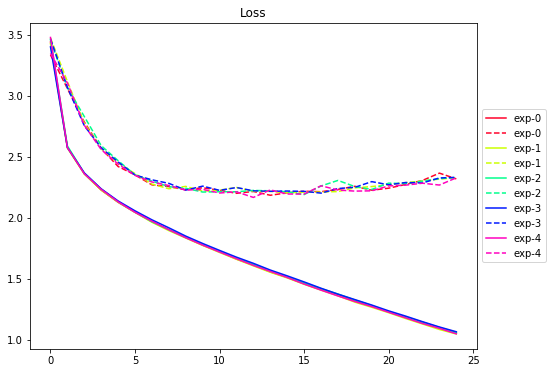

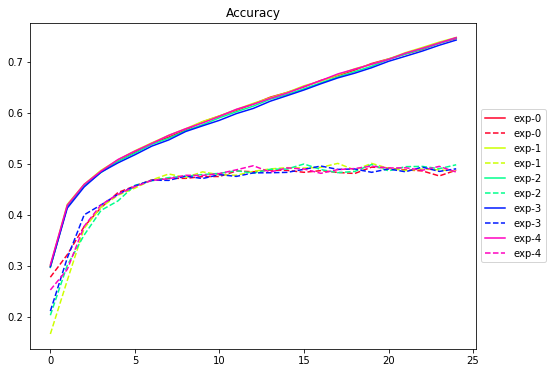

In [80]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()